In [69]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss

import cooper
from cooper.optim import SGD
import style_utils

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Mixture of Gaussians

This example is inspired by Fig. 2 in Cotter et al. (2019)

In [70]:
# Generate dataset
n_per_class = 100
dim = 2
n_gaussians = 4
mus = [(0, 1), (-1, 0), (0, -1), (1, 0)]
mus = [torch.tensor(m) for m in mus]
var = 0.05

inputs, labels = [], []

for id in range(n_gaussians):
    # Generate input data by mu + x @ sqrt(cov)
    cov = np.sqrt(var) * torch.eye(dim)
    mu = mus[id]
    inputs.append(mu + torch.randn(n_per_class, dim) @ cov)

    # Labels
    labels.append(torch.tensor(n_per_class * [1. if id < 2 else 0.]))

INPUTS = torch.cat(inputs, dim=0)
LABELS = torch.cat(labels, dim=0)

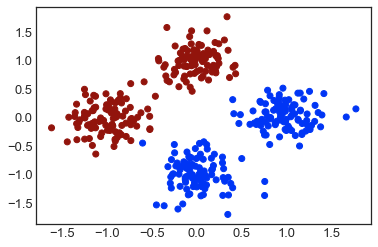

In [71]:
red, blue = style_utils.COLOR_DICT['red'], style_utils.COLOR_DICT['blue']
COLORS = [red if l == 1 else blue for l in LABELS.flatten()]

plt.scatter(*torch.transpose(INPUTS, 0, 1), color=COLORS)

### Constrained Minimization Problem

In [72]:
class MixtureSeparation(cooper.ConstrainedMinimizationProblem):
    def __init__(self, is_constrained, use_proxy=False):

        super().__init__(is_constrained=is_constrained)

        self.use_proxy = use_proxy

        # Linear predictor
        self.linear = torch.nn.Linear(2, 1)

    def closure(self, inputs, targets):

        logits = self.linear(inputs)
        loss=bce_loss(logits.flatten(), targets)

        if not self.is_constrained:
            # Unconstrained problem of separating two classes
            state = cooper.CMPState(
                loss=loss,
            )

        if self.is_constrained:
            # Separating classes s.t. predicting at least 55% as class 0 (blue)

            probs = torch.sigmoid(logits)
            # Hinge approximation of the rate

            if not self.use_proxy:
                # Use a proxy for the constraint: a hinge relaxation
                state = cooper.CMPState(
                    loss=loss,
                    ineq_defect=_,
                )
            else:
                # Use non-proxy constraint defects to update the Lagrange multipliers

                # Proportion of elements in class 0 is the non-proxy defect
                classes = torch.round(probs)
                prop_0 = torch.sum(classes == 0) / targets.numel()

                state = cooper.CMPState(
                    loss=loss,
                    ineq_defect=_,
                    proxy_defect=0.55 - prop_0, # 55% - prop_0 <= 0
                )

        return state

### Training

In [86]:
models = []

for problem in ["unconstrained"]:#, "constrained", "proxy"]:

    is_constrained = problem == "constrained" or problem == "proxy"
    use_proxy = problem == "proxy"

    cmp = MixtureSeparation(is_constrained, use_proxy)
    formulation = cooper.LagrangianFormulation(cmp)

    primal_optimizer = SGD(cmp.linear.parameters(), lr=1e-1)
    dual_optimizer = cooper.optim.partial(SGD, lr=1e-1) if is_constrained else None
    optimizer = cooper.ConstrainedOptimizer(
        formulation=formulation,
        primal_optimizer=primal_optimizer,
        dual_optimizer=dual_optimizer,
    )

    for i in range(1000):
        optimizer.zero_grad()
        if is_constrained:
            lagrangian = formulation.composite_objective(cmp.closure, INPUTS, LABELS)
            formulation.custom_backward(lagrangian)
        else:
            loss = cmp.closure(INPUTS, LABELS).loss
            loss.backward()
            if i % 100 == 0:
                print(loss.item())

        optimizer.step()

    models.append(cmp.linear)

0.47092944383621216
0.19493965804576874
0.12729978561401367
0.09651000797748566
0.07877679169178009
0.06718230992555618
0.05897326394915581
0.052834752947092056
0.048058051615953445
0.044226694852113724


### Resulting boundary

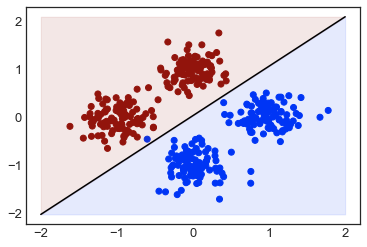

In [111]:
w = models[0].weight.data.flatten().numpy()
b = models[0].bias.data.numpy()

m = -w[0]/w[1]
b = -b/w[1]

x1 = np.linspace(-2, 2, 100)
x2 = m*x1 + b

plt.scatter(*torch.transpose(INPUTS, 0, 1), color=COLORS)
plt.plot(x1, x2, color="black")
plt.fill_between(x1, min(x2), x2, color=blue, alpha=0.1)
plt.fill_between(x1, x2, max(x2), color=red, alpha=0.1)

## References

- A. Cotter, H. Jiang, M. Gupta, S. Wang, T. Narayan, S. You,
and K. Sridharan. Optimization with Non-Differentiable
Constraints with Applications to Fairness, Recall, Churn,
and Other Goals. In JMLR, 2019.